 # Correlation Analysis: Tree Water Deficit Stress vs Swiss EO Vegetation Health Index



 This notebook analyzes the correlation between:

 - **signalTWD_norm**: Tree water deficit stress levels (1=low stress, 4=highest stress)

 - **swissEOVHI**: Swiss EO Vegetation Health Index (0-100)



 **Data Validation Rules:**

 - Valid data: `swissEOMASK == 0` AND `swissEOVHI <= 100`

 - Invalid data: `swissEOMASK != 0` OR `swissEOVHI > 100`

 ## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# File path
inputfilepath= r"C:\temp\satromo-dev\output\\"


In [2]:
# Read the CSV file
try:
    # List all files in the directory ending with *swisseo.csv
    files = [f for f in os.listdir(inputfilepath) if f.endswith("swisseo.csv")]
    if not files:
        print("❌ Error: No files ending with *swisseo.csv found in the directory.")
        raise FileNotFoundError("No matching files found.")

    # Load all matching files into a single DataFrame
    dfs = []
    for file in files:
        filepath = os.path.join(inputfilepath, file)
        try:
            df_temp = pd.read_csv(filepath)
            dfs.append(df_temp)
            print(f"✓ Data loaded successfully from {file}. Shape: {df_temp.shape}")
        except Exception as e:
            print(f"❌ Error loading file {file}: {e}")
            raise

    # Concatenate all DataFrames
    df = pd.concat(dfs, ignore_index=True)
    print(f"\n✓ All files concatenated successfully. Combined Shape: {df.shape}")
    print(f"✓ Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    display(df.head())

except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    raise


✓ Data loaded successfully from TN_2017_swisseo.csv. Shape: (30114, 14)
✓ Data loaded successfully from TN_2018_swisseo.csv. Shape: (30744, 14)
✓ Data loaded successfully from TN_2019_swisseo.csv. Shape: (36456, 14)
✓ Data loaded successfully from TN_2020_swisseo.csv. Shape: (38006, 14)
✓ Data loaded successfully from TN_2021_swisseo.csv. Shape: (47311, 14)
✓ Data loaded successfully from TN_2022_swisseo.csv. Shape: (74613, 14)
✓ Data loaded successfully from TN_2023_swisseo.csv. Shape: (90055, 14)

✓ All files concatenated successfully. Combined Shape: (347299, 14)
✓ Columns: ['series_id', 'doy', 'year', 'twd_norm', 'signalTWD_norm', 'tree_xcor', 'tree_ycor', 'tree_altitude', 'tree_gs', 'site_name', 'measure_point', 'DATETIME', 'swissEOVHI', 'swissEOMASK']

First few rows:


,series_id,doy,year,twd_norm,signalTWD_norm,tree_xcor,tree_ycor,tree_altitude,tree_gs,site_name,measure_point,DATETIME,swissEOVHI,swissEOMASK
0,73,1,2017,0.0,1,8.454529,47.362910,542.529,Fagus sylvatica,Birmensdorf-Forest,birmensdorf-forest_dendrometer_µm_buche-49_0_1...,2017-01-01,120,120
1,1167,1,2017,0.0,1,9.066944,47.165802,715.359,Fraxinus excelsior,Schaenis-low,schaenis-low_dendrometer_µm_baum-1202_0_1.5_no...,2017-01-01,120,120
2,120,1,2017,0.0,1,7.677172,47.460875,659.681,Quercus petraea,Bueren-Forest,bueren-forest_dendrometer_µm_n1_0_1.5_northwes...,2017-01-01,120,120
3,1271,1,2017,0.0,1,9.623876,46.674708,1199.000,Pinus sylvestris,Surava-North,surava-north_dendrometer_µm_föhre-sc4_0_1.5_ea...,2017-01-01,120,120
4,853,1,2017,0.0,1,8.535689,47.683560,583.665,Quercus petraea,Neunkirch-Southeast,neunkirch-southeast_dendrometer_µm_eiche-1_0_1...,2017-01-01,120,120


 ## 2. Data Exploration and Quality Assessment

In [3]:
# Basic data info
print("="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nData types:")
display(df.dtypes)


DATA OVERVIEW
Dataset shape: (347299, 14)
Memory usage: 142.26 MB

Data types:


series_id           int64
doy                 int64
year                int64
twd_norm          float64
signalTWD_norm      int64
tree_xcor         float64
tree_ycor         float64
tree_altitude     float64
tree_gs            object
site_name          object
measure_point      object
DATETIME           object
swissEOVHI          int64
swissEOMASK         int64
dtype: object

In [4]:
# Check for missing values
print("="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)
missing_summary = df.isnull().sum()
missing_pct = (missing_summary / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)

print("Missing values per column:")
display(missing_df[missing_df['Missing_Count'] > 0])


MISSING VALUES ANALYSIS
Missing values per column:


,Missing_Count,Missing_Percentage


In [5]:
# Analyze our key variables before cleaning
print("="*60)
print("KEY VARIABLES - RAW DATA ANALYSIS")
print("="*60)

key_vars = ['signalTWD_norm', 'swissEOVHI', 'swissEOMASK']

# Filter data for DOY between 90 and 274 (April 1 to September 30 - Growing Season)
DOY_start = 1
DOY_end = 365
print("Applying DOY filter: 90-274 (April 1 to September 30)")
print(f"Original dataset: {len(df)} rows")
df_filtered = df[(df['doy'] >= DOY_start) & (df['doy'] <= DOY_end)]
print(f"After DOY filter: {len(df_filtered)} rows ({(len(df_filtered)/len(df))*100:.1f}% retained)")

print(f"\nDOY distribution in filtered data:")
print(f"DOY range: {df_filtered['doy'].min()} to {df_filtered['doy'].max()}")
print(f"DOY statistics:")
print(df_filtered['doy'].describe())

for var in key_vars:
    if var in df_filtered.columns:
        print(f"\n{var} - Filtered Statistics (DOY {DOY_start}-{DOY_end}):")
        print(df_filtered[var].describe())
        print(f"Unique values: {sorted(df_filtered[var].unique())}")

        # Special analysis for swissEOMASK and swissEOVHI
        if var == 'swissEOMASK':
            mask_counts = df_filtered[var].value_counts().sort_index()
            print(f"swissEOMASK value counts:")
            for value, count in mask_counts.items():
                pct = (count / len(df_filtered)) * 100
                print(f"  {value}: {count} ({pct:.1f}%)")

        elif var == 'swissEOVHI':
            print(f"Values > 100: {(df_filtered[var] > 100).sum()} ({((df_filtered[var] > 100).sum() / len(df_filtered)) * 100:.1f}%)")
            print(f"Values <= 100: {(df_filtered[var] <= 100).sum()} ({((df_filtered[var] <= 100).sum() / len(df_filtered)) * 100:.1f}%)")


KEY VARIABLES - RAW DATA ANALYSIS
Applying DOY filter: 90-274 (April 1 to September 30)
Original dataset: 347299 rows
After DOY filter: 347299 rows (100.0% retained)

DOY distribution in filtered data:
DOY range: 1 to 365
DOY statistics:
count    347299.000000
mean        186.122995
std         105.014386
min           1.000000
25%          96.000000
50%         187.000000
75%         278.000000
max         365.000000
Name: doy, dtype: float64

signalTWD_norm - Filtered Statistics (DOY 1-365):
count    347299.000000
mean          2.018834
std           1.017992
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: signalTWD_norm, dtype: float64
Unique values: [1, 2, 3, 4]

swissEOVHI - Filtered Statistics (DOY 1-365):
count    347299.000000
mean        106.630880
std          59.411823
min           0.000000
25%          66.000000
50%         110.000000
75%         120.000000
max         255.000000
Name: swissEOVHI, dty

 ## 3. Data Validation and Cleaning

In [6]:
print("="*60)
print("DATA VALIDATION AND CLEANING")
print("="*60)

# Apply validation rules to the DOY-filtered data
print("Applying validation rules to DOY-filtered data:")
print("✓ Valid data: swissEOMASK == 0 AND swissEOVHI <= 100")
print("✗ Invalid data: swissEOMASK != 0 OR swissEOVHI > 100")

# Count data before cleaning
total_filtered_rows = len(df_filtered)
print(f"\nDOY-filtered dataset: {total_filtered_rows} rows")

# Check validation conditions
mask_valid = df_filtered['swissEOMASK'] == 0
vhi_valid = df_filtered['swissEOVHI'] <= 100
both_valid = mask_valid & vhi_valid

print(f"Rows with swissEOMASK == 0: {mask_valid.sum()} ({(mask_valid.sum()/total_filtered_rows)*100:.1f}%)")
print(f"Rows with swissEOVHI <= 100: {vhi_valid.sum()} ({(vhi_valid.sum()/total_filtered_rows)*100:.1f}%)")
print(f"Rows meeting both conditions: {both_valid.sum()} ({(both_valid.sum()/total_filtered_rows)*100:.1f}%)")

# Create cleaned dataset
df_valid = df_filtered[both_valid].copy()

# Remove rows with missing values in key analysis variables
analysis_vars = ['signalTWD_norm', 'swissEOVHI']
df_clean = df_valid.dropna(subset=analysis_vars)

print(f"\nAfter validation: {len(df_valid)} rows")
print(f"After removing missing values in analysis variables: {len(df_clean)} rows")
print(f"Final dataset for analysis: {len(df_clean)} rows ({(len(df_clean)/total_filtered_rows)*100:.1f}% of DOY-filtered data)")
print(f"Overall retention from original data: {(len(df_clean)/len(df))*100:.1f}%")


DATA VALIDATION AND CLEANING
Applying validation rules to DOY-filtered data:
✓ Valid data: swissEOMASK == 0 AND swissEOVHI <= 100
✗ Invalid data: swissEOMASK != 0 OR swissEOVHI > 100

DOY-filtered dataset: 347299 rows
Rows with swissEOMASK == 0: 39100 (11.3%)
Rows with swissEOVHI <= 100: 117991 (34.0%)
Rows meeting both conditions: 25016 (7.2%)

After validation: 25016 rows
After removing missing values in analysis variables: 25016 rows
Final dataset for analysis: 25016 rows (7.2% of DOY-filtered data)
Overall retention from original data: 7.2%


In [7]:
# Validate the cleaned data ranges
print("="*60)
print("CLEANED DATA VALIDATION")
print("="*60)

print("signalTWD_norm (stress levels):")
print(f"  Range: {df_clean['signalTWD_norm'].min()} to {df_clean['signalTWD_norm'].max()}")
print(f"  Unique values: {sorted(df_clean['signalTWD_norm'].unique())}")
print(f"  Expected: 1-4 ✓" if set(df_clean['signalTWD_norm'].unique()).issubset({1,2,3,4}) else f"  ⚠️ Unexpected values found")

print(f"\nswissEOVHI (vegetation health index):")
print(f"  Range: {df_clean['swissEOVHI'].min():.1f} to {df_clean['swissEOVHI'].max():.1f}")
print(f"  Expected: 0-100 ✓" if df_clean['swissEOVHI'].min() >= 0 and df_clean['swissEOVHI'].max() <= 100 else f"  ⚠️ Values outside expected range")

print(f"\nswissEOMASK (should all be 0):")
print(f"  Unique values: {sorted(df_clean['swissEOMASK'].unique())}")
print(f"  All zeros: ✓" if list(df_clean['swissEOMASK'].unique()) == [0] else f"  ⚠️ Non-zero values found")


CLEANED DATA VALIDATION
signalTWD_norm (stress levels):
  Range: 1 to 4
  Unique values: [1, 2, 3, 4]
  Expected: 1-4 ✓

swissEOVHI (vegetation health index):
  Range: 0.0 to 100.0
  Expected: 0-100 ✓

swissEOMASK (should all be 0):
  Unique values: [0]
  All zeros: ✓


 ## 4. Descriptive Statistics

In [8]:
print("="*60)
print("DESCRIPTIVE STATISTICS - CLEANED DATA")
print("="*60)

# Overall statistics
print("Overall Statistics:")
display(df_clean[['signalTWD_norm', 'swissEOVHI']].describe())

# Distribution by stress level
print("\nswissEOVHI Statistics by Stress Level:")
stress_stats = df_clean.groupby('signalTWD_norm')['swissEOVHI'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(2)
stress_stats.columns = ['Count', 'Mean', 'Std Dev', 'Min', 'Max', 'Median']
display(stress_stats)


DESCRIPTIVE STATISTICS - CLEANED DATA
Overall Statistics:


,signalTWD_norm,swissEOVHI
count,25016.00000,25016.000000
mean,2.20315,52.447074
std,1.05419,23.609462
min,1.00000,0.000000
25%,1.00000,37.000000
50%,2.00000,53.000000
75%,3.00000,69.000000
max,4.00000,100.000000



swissEOVHI Statistics by Stress Level:


,Count,Mean,Std Dev,Min,Max,Median
signalTWD_norm,,,,,,
1,8199,55.29,23.20,0,100,56.0
2,7212,54.03,23.69,0,100,55.0
3,5929,50.05,23.17,0,100,51.0
4,3676,46.87,23.72,0,100,47.0


 ## 5. Correlation Analysis

In [9]:
print("="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Extract variables for analysis
signal_twd = df_clean['signalTWD_norm']
swiss_eovhi = df_clean['swissEOVHI']

# Calculate correlations
pearson_corr, pearson_p = pearsonr(signal_twd, swiss_eovhi)
spearman_corr, spearman_p = spearmanr(signal_twd, swiss_eovhi)

print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
print(f"Pearson p-value: {pearson_p:.4f}")
print(f"Spearman correlation coefficient: {spearman_corr:.4f}")
print(f"Spearman p-value: {spearman_p:.4f}")

# Interpretation function
def interpret_correlation(corr):
    abs_corr = abs(corr)
    if abs_corr >= 0.7:
        strength = "strong"
    elif abs_corr >= 0.3:
        strength = "moderate"
    elif abs_corr >= 0.1:
        strength = "weak"
    else:
        strength = "very weak/negligible"

    direction = "positive" if corr > 0 else "negative"
    return f"{strength} {direction}"

print(f"\nInterpretation:")
print(f"Pearson: {interpret_correlation(pearson_corr)} correlation")
print(f"Spearman: {interpret_correlation(spearman_corr)} correlation")

significance_level = 0.05
print(f"\nStatistical Significance (α = {significance_level}):")
print(f"Pearson: {'Significant' if pearson_p < significance_level else 'Not significant'} (p = {pearson_p:.4f})")
print(f"Spearman: {'Significant' if spearman_p < significance_level else 'Not significant'} (p = {spearman_p:.4f})")


CORRELATION ANALYSIS
Pearson correlation coefficient: -0.1261
Pearson p-value: 0.0000
Spearman correlation coefficient: -0.1264
Spearman p-value: 0.0000

Interpretation:
Pearson: weak negative correlation
Spearman: weak negative correlation

Statistical Significance (α = 0.05):
Pearson: Significant (p = 0.0000)
Spearman: Significant (p = 0.0000)


 ## 6. Visualization

D:\Users\david-oesch-w1\AppData\Local\Temp\1\ipykernel_6188\2952960367.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=sorted(df_clean['signalTWD_norm'].unique()), patch_artist=True)


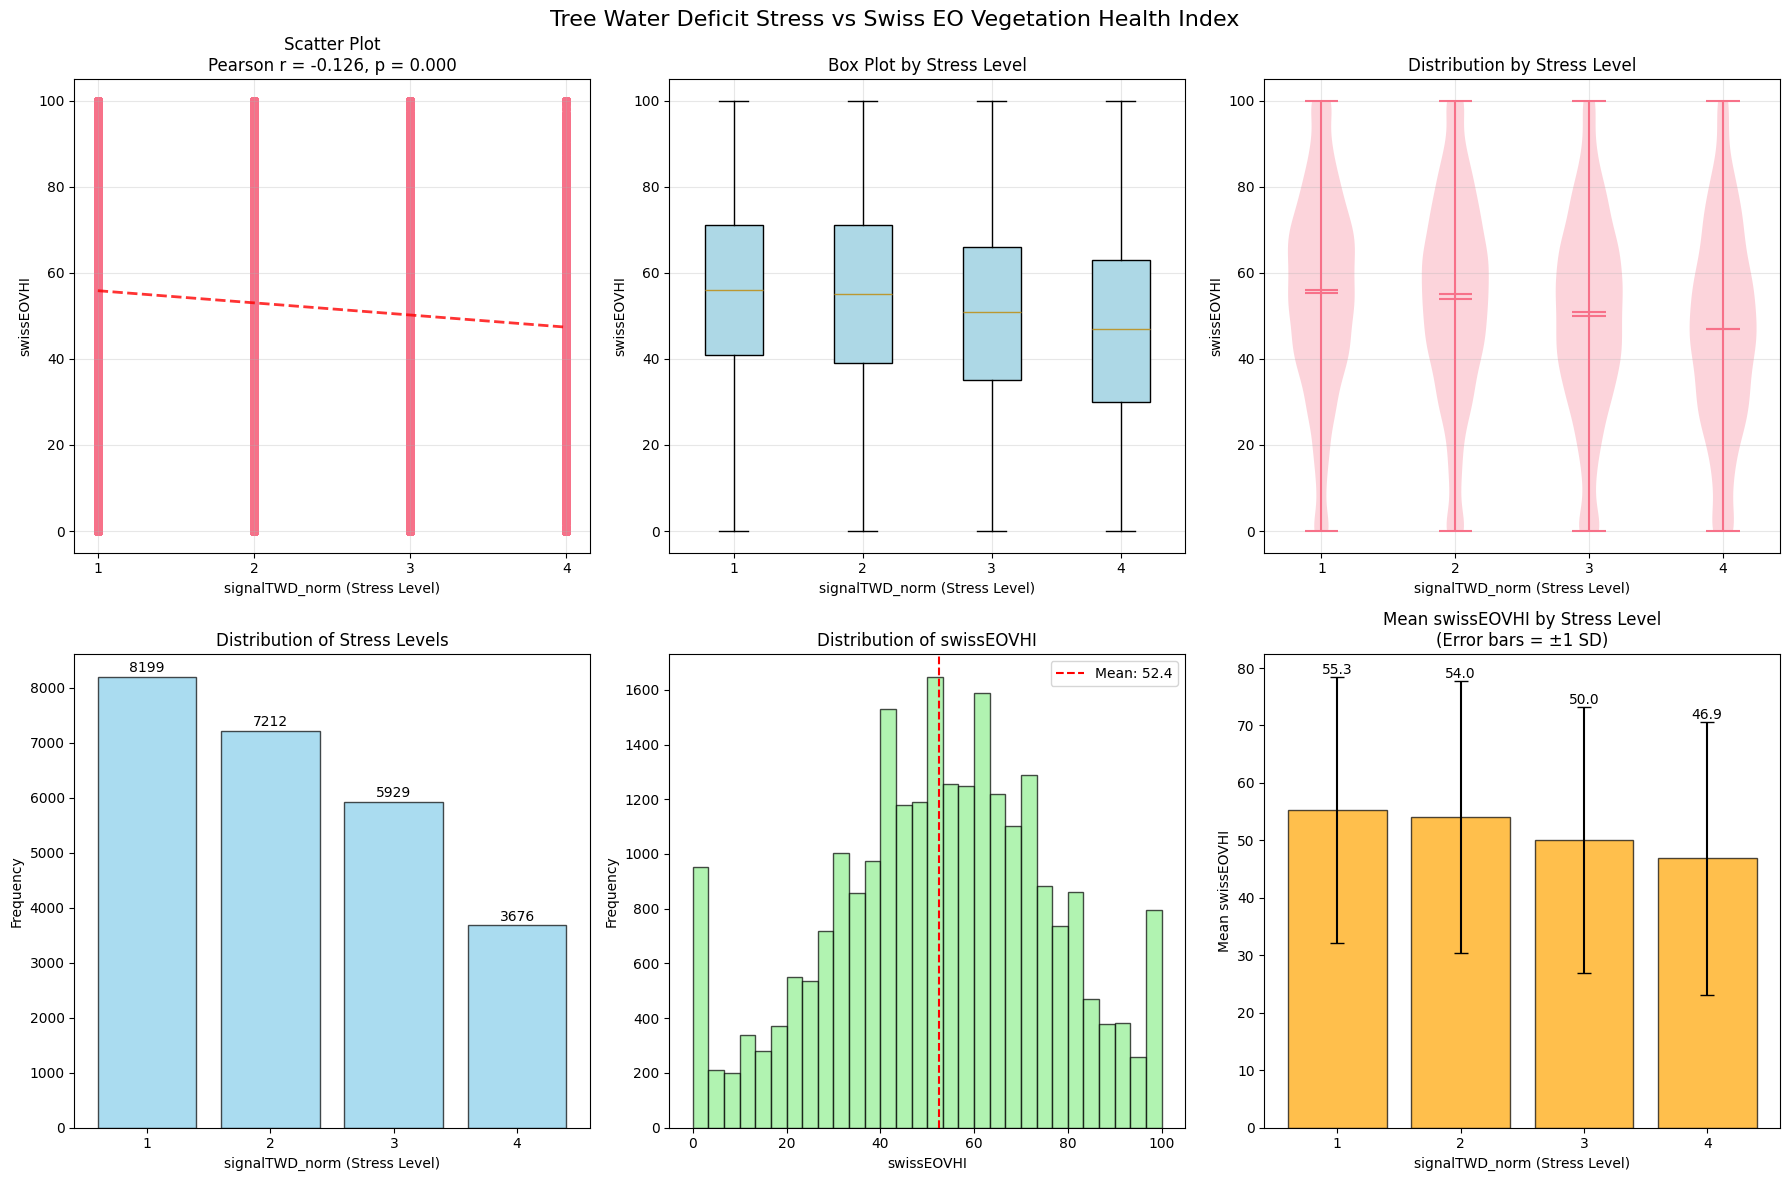

In [10]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Tree Water Deficit Stress vs Swiss EO Vegetation Health Index', fontsize=16, y=0.98)

# 1. Scatter plot
ax1 = axes[0, 0]
ax1.scatter(signal_twd, swiss_eovhi, alpha=0.6, s=30)
ax1.set_xlabel('signalTWD_norm (Stress Level)')
ax1.set_ylabel('swissEOVHI')
ax1.set_title(f'Scatter Plot\nPearson r = {pearson_corr:.3f}, p = {pearson_p:.3f}')
ax1.set_xticks([1, 2, 3, 4])
ax1.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(signal_twd, swiss_eovhi, 1)
p = np.poly1d(z)
ax1.plot(sorted(signal_twd), p(sorted(signal_twd)), "r--", alpha=0.8, linewidth=2)

# 2. Box plot
ax2 = axes[0, 1]
box_data = [df_clean[df_clean['signalTWD_norm'] == i]['swissEOVHI'].values
            for i in sorted(df_clean['signalTWD_norm'].unique())]
bp = ax2.boxplot(box_data, labels=sorted(df_clean['signalTWD_norm'].unique()), patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax2.set_xlabel('signalTWD_norm (Stress Level)')
ax2.set_ylabel('swissEOVHI')
ax2.set_title('Box Plot by Stress Level')
ax2.grid(True, alpha=0.3)

# 3. Violin plot
ax3 = axes[0, 2]
parts = ax3.violinplot([df_clean[df_clean['signalTWD_norm'] == i]['swissEOVHI'].values
                        for i in sorted(df_clean['signalTWD_norm'].unique())],
                       positions=sorted(df_clean['signalTWD_norm'].unique()),
                       showmeans=True, showmedians=True)
ax3.set_xlabel('signalTWD_norm (Stress Level)')
ax3.set_ylabel('swissEOVHI')
ax3.set_title('Distribution by Stress Level')
ax3.set_xticks(sorted(df_clean['signalTWD_norm'].unique()))
ax3.grid(True, alpha=0.3)

# 4. Histogram of stress levels
ax4 = axes[1, 0]
stress_counts = df_clean['signalTWD_norm'].value_counts().sort_index()
ax4.bar(stress_counts.index, stress_counts.values, alpha=0.7, color='skyblue', edgecolor='black')
ax4.set_xlabel('signalTWD_norm (Stress Level)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Stress Levels')
ax4.set_xticks([1, 2, 3, 4])
for i, v in enumerate(stress_counts.values):
    ax4.text(stress_counts.index[i], v + max(stress_counts.values)*0.01, str(v), ha='center')

# 5. Histogram of swissEOVHI
ax5 = axes[1, 1]
ax5.hist(swiss_eovhi, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
ax5.set_xlabel('swissEOVHI')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of swissEOVHI')
ax5.axvline(swiss_eovhi.mean(), color='red', linestyle='--', label=f'Mean: {swiss_eovhi.mean():.1f}')
ax5.legend()

# 6. Mean and error bars
ax6 = axes[1, 2]
means = stress_stats['Mean']
stds = stress_stats['Std Dev']
bars = ax6.bar(means.index, means.values, yerr=stds.values, capsize=5,
               alpha=0.7, color='orange', edgecolor='black')
ax6.set_xlabel('signalTWD_norm (Stress Level)')
ax6.set_ylabel('Mean swissEOVHI')
ax6.set_title('Mean swissEOVHI by Stress Level\n(Error bars = ±1 SD)')
ax6.set_xticks([1, 2, 3, 4])
# Add value labels on bars
for bar, mean_val in zip(bars, means.values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + stds.iloc[bars.index(bar)],
             f'{mean_val:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


 ## 7. Statistical Tests

In [11]:
print("="*60)
print("ADDITIONAL STATISTICAL TESTS")
print("="*60)

# ANOVA test to check if means differ significantly across stress levels
from scipy.stats import f_oneway

stress_groups = [df_clean[df_clean['signalTWD_norm'] == i]['swissEOVHI'].values
                 for i in sorted(df_clean['signalTWD_norm'].unique())]

f_stat, anova_p = f_oneway(*stress_groups)
print(f"One-way ANOVA:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {anova_p:.4f}")
print(f"Result: {'Significant differences' if anova_p < 0.05 else 'No significant differences'} between stress level means")

# Kruskal-Wallis test (non-parametric alternative)
from scipy.stats import kruskal
kw_stat, kw_p = kruskal(*stress_groups)
print(f"\nKruskal-Wallis test (non-parametric):")
print(f"H-statistic: {kw_stat:.4f}")
print(f"p-value: {kw_p:.4f}")
print(f"Result: {'Significant differences' if kw_p < 0.05 else 'No significant differences'} between stress level distributions")


ADDITIONAL STATISTICAL TESTS
One-way ANOVA:
F-statistic: 141.5581
p-value: 0.0000
Result: Significant differences between stress level means

Kruskal-Wallis test (non-parametric):
H-statistic: 442.3311
p-value: 0.0000
Result: Significant differences between stress level distributions


 ## 8. Site-Specific Analysis

SITE-SPECIFIC ANALYSIS
Site-specific correlations (sites with ≥10 observations):


,Site,N_Observations,Pearson_r,Pearson_p,Spearman_r,Spearman_p,Mean_VHI,Std_VHI
0,Chippis-East,1005,-0.1037,0.0010,-0.1053,0.0008,51.3353,20.1240
1,Pfynwald-Irrigation,1368,-0.1010,0.0002,-0.1234,0.0000,69.3596,25.3496
2,Novaggio-Forest,1711,-0.0707,0.0034,-0.0706,0.0035,53.4705,21.7088
3,Hohtenn-Gampel-Forest,629,-0.2184,0.0000,-0.2045,0.0000,47.0620,21.2336
4,Pfynwald-Illgraben-Northwest,486,-0.3157,0.0000,-0.3363,0.0000,53.5082,23.1748
5,Chippis-Hilltop,544,-0.0599,0.1628,-0.0648,0.1313,53.7132,24.2746
6,Saillon-A860,371,-0.1858,0.0003,-0.2116,0.0000,49.2318,22.0893
7,Pfynwald-Control,642,-0.1091,0.0057,-0.1149,0.0035,41.6838,20.8043
8,Lens-Forest,186,-0.1619,0.0273,-0.1828,0.0125,52.7849,18.0263
9,Lausanne-Forest,391,-0.0154,0.7613,-0.0113,0.8240,53.7212,18.5988


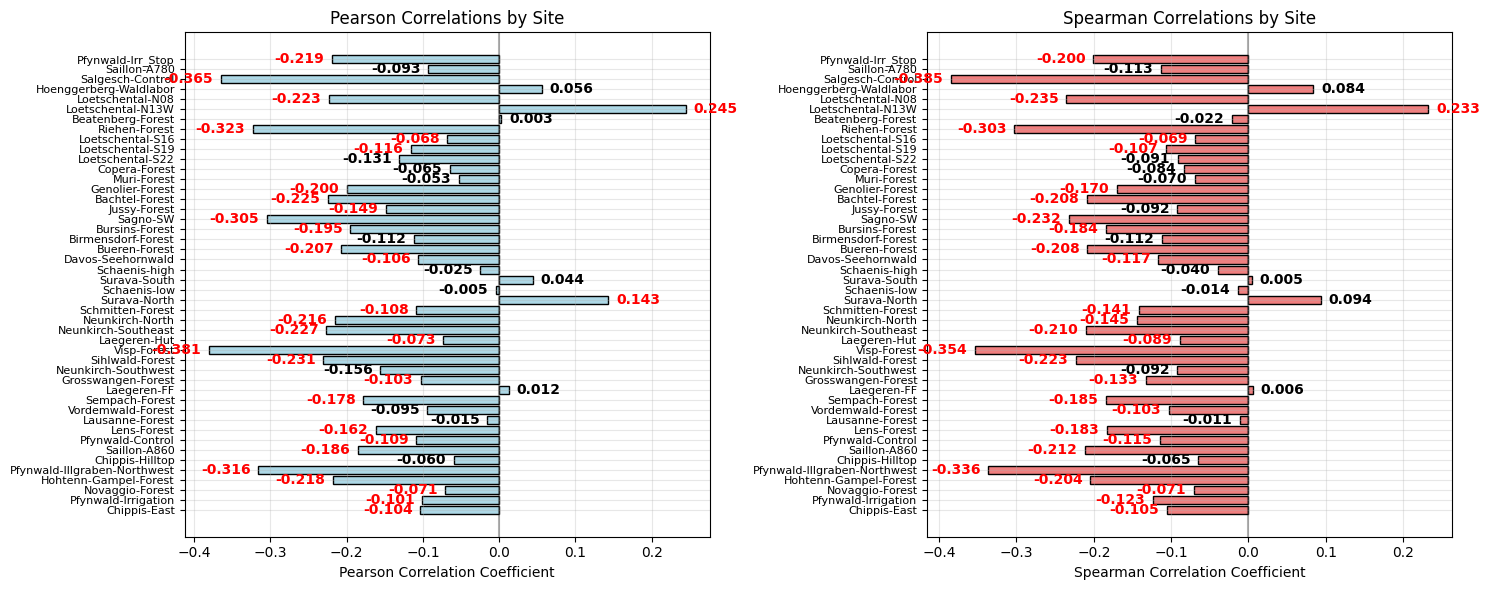


Note: Red text indicates statistically significant correlations (p < 0.05)


In [12]:
print("="*60)
print("SITE-SPECIFIC ANALYSIS")
print("="*60)

# Analyze correlations by site
site_correlations = []
min_observations = 10  # Minimum observations per site for reliable correlation

for site in df_clean['site_name'].unique():
    site_data = df_clean[df_clean['site_name'] == site]
    n_obs = len(site_data)

    if n_obs >= min_observations:
        site_pearson, site_p_pearson = pearsonr(site_data['signalTWD_norm'], site_data['swissEOVHI'])
        site_spearman, site_p_spearman = spearmanr(site_data['signalTWD_norm'], site_data['swissEOVHI'])

        site_correlations.append({
            'Site': site,
            'N_Observations': n_obs,
            'Pearson_r': site_pearson,
            'Pearson_p': site_p_pearson,
            'Spearman_r': site_spearman,
            'Spearman_p': site_p_spearman,
            'Mean_VHI': site_data['swissEOVHI'].mean(),
            'Std_VHI': site_data['swissEOVHI'].std()
        })

if site_correlations:
    site_df = pd.DataFrame(site_correlations)
    site_df = site_df.round(4)
    print(f"Site-specific correlations (sites with ≥{min_observations} observations):")
    display(site_df)

    # Plot site-specific correlations
    if len(site_df) > 1:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Pearson correlations by site
        ax1.barh(range(len(site_df)), site_df['Pearson_r'], color='lightblue', edgecolor='black')
        ax1.set_yticks(range(len(site_df)))
        ax1.set_yticklabels(site_df['Site'], fontsize=8)
        ax1.set_xlabel('Pearson Correlation Coefficient')
        ax1.set_title('Pearson Correlations by Site')
        ax1.axvline(0, color='black', linestyle='-', alpha=0.3)
        ax1.grid(True, alpha=0.3)

        # Add correlation values as text
        for i, (r, p) in enumerate(zip(site_df['Pearson_r'], site_df['Pearson_p'])):
            color = 'red' if p < 0.05 else 'black'
            ax1.text(r + 0.01 if r >= 0 else r - 0.01, i, f'{r:.3f}',
                    va='center', ha='left' if r >= 0 else 'right', color=color, fontweight='bold')

        # Spearman correlations by site
        ax2.barh(range(len(site_df)), site_df['Spearman_r'], color='lightcoral', edgecolor='black')
        ax2.set_yticks(range(len(site_df)))
        ax2.set_yticklabels(site_df['Site'], fontsize=8)
        ax2.set_xlabel('Spearman Correlation Coefficient')
        ax2.set_title('Spearman Correlations by Site')
        ax2.axvline(0, color='black', linestyle='-', alpha=0.3)
        ax2.grid(True, alpha=0.3)

        # Add correlation values as text
        for i, (r, p) in enumerate(zip(site_df['Spearman_r'], site_df['Spearman_p'])):
            color = 'red' if p < 0.05 else 'black'
            ax2.text(r + 0.01 if r >= 0 else r - 0.01, i, f'{r:.3f}',
                    va='center', ha='left' if r >= 0 else 'right', color=color, fontweight='bold')

        plt.tight_layout()
        plt.show()

        print("\nNote: Red text indicates statistically significant correlations (p < 0.05)")

else:
    print(f"No sites have ≥{min_observations} observations for reliable correlation analysis")


 ## 9. Summary and Conclusions

In [ ]:
print("="*80)
print("SUMMARY AND CONCLUSIONS")
print("="*80)

print("="*80)
print("SUMMARY AND CONCLUSIONS")
print("="*80)

print(f"Dataset Summary:")
print(f"├─ Original dataset: {len(df):,} rows")
print(f"├─ DOY filtered ({DOY_start}-{DOY_end}): {total_filtered_rows:,} rows ({(total_filtered_rows/len(df))*100:.1f}%)")
print(f"├─ Valid data (swissEOMASK=0 & swissEOVHI≤100): {len(df_valid):,} rows ({(len(df_valid)/total_filtered_rows)*100:.1f}%)")
print(f"└─ Final analysis dataset: {len(df_clean):,} rows ({(len(df_clean)/len(df))*100:.1f}% of original)")

print(f"\nSeason Focus (DOY {DOY_start}-{DOY_end}):")
# print(f"├─ April 1 to September 30")
# print(f"├─ Captures peak vegetation activity period")
# print(f"└─ Excludes winter dormancy and early spring/late fall periods")

print(f"\nCorrelation Results:")
print(f"├─ Pearson correlation: {pearson_corr:.4f} ({interpret_correlation(pearson_corr)})")
print(f"│  └─ Significance: {'✓ Significant' if pearson_p < 0.05 else '✗ Not significant'} (p = {pearson_p:.4f})")
print(f"└─ Spearman correlation: {spearman_corr:.4f} ({interpret_correlation(spearman_corr)})")
print(f"   └─ Significance: {'✓ Significant' if spearman_p < 0.05 else '✗ Not significant'} (p = {spearman_p:.4f})")

print(f"\nRecommendations:")
print(f"├─ Use Spearman correlation for ordinal stress levels (1-4)")
if abs(spearman_corr) > abs(pearson_corr):
    print(f"├─ Spearman correlation is stronger, suggesting non-linear relationship")
else:
    print(f"├─ Similar correlation coefficients suggest linear relationship")

if len(site_correlations) > 0:
    significant_sites = sum(1 for site in site_correlations if site['Spearman_p'] < 0.05)
    print(f"└─ Site-specific analysis: {significant_sites}/{len(site_correlations)} sites show significant correlations")

print(f"\nBiological Interpretation:")
if spearman_corr > 0:
    print(f"├─ Positive correlation: Higher tree stress associated with higher vegetation health index")
    print(f"└─ This might seem counterintuitive - investigate potential confounding factors")
elif spearman_corr < 0:
    print(f"├─ Negative correlation: Higher tree stress associated with lower vegetation health index")
    print(f"└─ This aligns with expected biological relationship")
else:
    print(f"└─ No meaningful correlation detected between tree stress and vegetation health")


SUMMARY AND CONCLUSIONS
SUMMARY AND CONCLUSIONS
Dataset Summary:
├─ Original dataset: 347,299 rows
├─ DOY filtered (1-365): 347,299 rows (100.0%)
├─ Valid data (swissEOMASK=0 & swissEOVHI≤100): 25,016 rows (7.2%)
└─ Final analysis dataset: 25,016 rows (7.2% of original)

Growing Season Focus (DOY 1-365):
├─ April 1 to September 30
├─ Captures peak vegetation activity period
└─ Excludes winter dormancy and early spring/late fall periods

Correlation Results:
├─ Pearson correlation: -0.1261 (weak negative)
│  └─ Significance: ✓ Significant (p = 0.0000)
└─ Spearman correlation: -0.1264 (weak negative)
   └─ Significance: ✓ Significant (p = 0.0000)

Recommendations:
├─ Use Spearman correlation for ordinal stress levels (1-4)
├─ Spearman correlation is stronger, suggesting non-linear relationship
└─ Site-specific analysis: 30/46 sites show significant correlations

Biological Interpretation:
├─ Negative correlation: Higher tree stress associated with lower vegetation health index
└─ This al

In [14]:
# %%